<a href="https://colab.research.google.com/github/AnupamaRajkumar/AppliedDeepLearning/blob/master/SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare dataset

### BSDS300
* LR: Low resolution, HR: high resolution, SR: super resolution
* Download the BSDS300 dataset. Here you can find more information about the dataset: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/
* After extracting it, convert them to YCrCb color space. We will use the luminance information (0th channel) only as the input of the CNN.
* Create 32x32 image patches with a sliding window (16 step size).
* Use 0.15 part of the train set as the validation set.
* The Y (0th) channel of the original images will be the ground truth. Create the LR images by resizing them half of the original size, then resize it back to the original size using cubic interpolation.
* Print the size of each set and plot 5 LR training images and their corresponding HR images. *Note: Don't forget to convert the color space from YCrCb back to RGB before plotting.*
* Normalize the datasets. All value should be between 0.0 and 1.0. *Note: you don't have to use standardization, you can just divide them by 255.*

Downloaded the BSDS300 dataset


In [ ]:
# BSDS300 dataset
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz
!tar -xvzf BSDS300-images.tgz

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import sklearn
import PIL
import PIL.Image

In [7]:
import tensorflow as tf
import os
from google.colab.patches import cv2_imshow

Accessing training folder paths and creating folder for saving the pre-processed datasets

In [8]:
path = '/content/BSDS300/images'
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')
print(train_path)
print(test_path)

/content/BSDS300/images/train
/content/BSDS300/images/test


Helper function to convert RGB image to YCrCb and vice versa


In [10]:
def convertBGRToYCrCb(img):
  YCrCbImg = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  return YCrCbImg

def convertYCrCbToRGB(img):
  RGBImg = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
  return RGBImg

Convert the images to YCrCb color space, create image patches and save as training set

In [11]:
def transformDataSamples(train_path):
  os.chdir(train_path)
  patches = []
  for img_idx in os.listdir(train_path):
    img_name = cv2.imread(img_idx)
    newImg = convertBGRToYCrCb(img_name)
    #y, cr, cb = cv2.split(newImg)
    #create 32x32 patches of these images with 16 step size
    height, width, _ = newImg.shape
    h = 0
    w = 0
    patchSize = 32
    stride = 16
    while( h < height and (height - h > patchSize)):
      while(w < width and (width - w > patchSize)):
        patch = newImg[h:h+patchSize, w:w+patchSize]
        patches.append(patch)
        w = w + stride
      h = h + stride
  return patches

In [12]:
patches = transformDataSamples(train_path)
print(len(patches))

5170


Create patches for the test set

In [13]:
testPatches = transformDataSamples(test_path)

print(len(testPatches))

2670


Helper functons to create a LR image

In [14]:
def createLowResolutionImage(img):
  imgDims = img.shape
  lrImg = cv2.resize(img, (int(imgDims[1]/2), int(imgDims[0]/2)))
  return lrImg

def createHighResolutionImage(img):
  imgDims = img.shape
  hrImg = cv2.resize(img, (imgDims[1]*2, imgDims[0]*2), interpolation=cv2.INTER_CUBIC)
  return hrImg

LR : low resolution image after cubic interpolation
HR : Original image
SR : Reconstructed image from LR image

creating LR images from test images

In [15]:
os.chdir(test_path)
lrImgs = []
hrImgs = []
for img_idx in os.listdir(test_path):
    img_name = cv2.imread(img_idx)
    newImg = convertBGRToYCrCb(img_name)
    hrImgs.append(newImg)
    #low resolution image
    lrImg = createLowResolutionImage(newImg)
    #convert back to high resolution
    lrImg = createHighResolutionImage(lrImg)
    lrImgs.append(lrImg)


-----------High resolution images----------


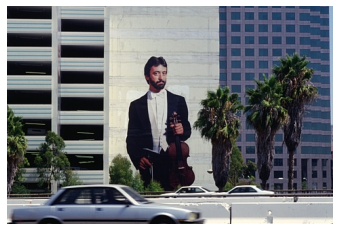

In [34]:
selected = np.random.choice(len(lrImgs), 1)
plt.figure()
print('-----------High resolution images----------')
for i, ind in enumerate(selected):
  plt.imshow(cv2.cvtColor(hrImgs[ind], cv2.COLOR_YCR_CB2RGB))
  plt.axis('off') 

-----------Low resolution images----------


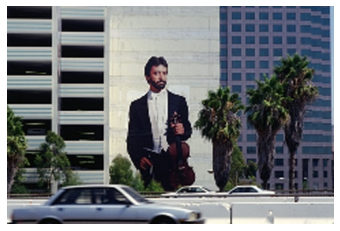

In [35]:
plt.figure()
print('-----------Low resolution images----------')
for i, ind in enumerate(selected):
  plt.imshow(cv2.cvtColor(lrImgs[ind], cv2.COLOR_YCR_CB2RGB))
  plt.axis('off') 

In [36]:
lrImgArr = np.array(lrImgs)
hrLabArr = np.array(hrImgs)


Creating LR patches of training set

In [37]:
lrPatch = []
for p_Idx in patches:
    #low resolution image
    lrImg = createLowResolutionImage(p_Idx)
    #convert back to high resolution
    lrImg = createHighResolutionImage(lrImg)
    lrPatch.append(lrImg)
print(len(lrPatch))

5170


Display some patches in their hr and lr versions

-----------High resolution images----------


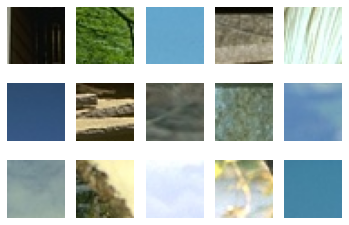

In [38]:
selected = np.random.choice(len(patches), 15)
plt.figure()
print('-----------High resolution images----------')
for i, ind in enumerate(selected):
  plt.subplot(3, 5, i+1)
  plt.imshow(convertYCrCbToRGB(patches[ind]))
  plt.axis('off') 

-----------Low resolution images----------


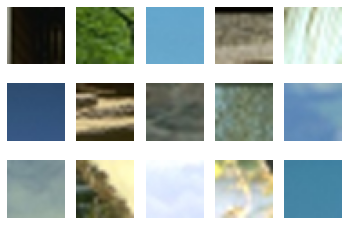

In [39]:
plt.figure()
print('-----------Low resolution images----------')
for i, ind in enumerate(selected):
  plt.subplot(3, 5, i+1)
  plt.imshow(convertYCrCbToRGB(lrPatch[ind]))
  plt.axis('off') 

Create LR patches of test set

In [40]:
lrTestPatch = []
for p_Idx in testPatches:
    #low resolution image
    lrImg = createLowResolutionImage(p_Idx)
    #convert back to high resolution
    lrImg = createHighResolutionImage(lrImg)
    lrTestPatch.append(lrImg)
print(len(lrTestPatch))

2670


Extract only Yth channel (0) from both training data and corresponding ground truth

In [41]:
train = []
label = []
for t in lrPatch:
  train.append(t[:, :, 0])

for l in patches:
  label.append(l[:, :, 0])

Extract Y (0th channel) from test dataset and corresponding ground truth

In [42]:
test = []
testLab = []
for t in lrTestPatch:
  test.append(t[:, :, 0])

for l in testPatches:
  testLab.append(l[:, :, 0])

testArr = np.array(test)
testLabArr = np.array(testLab)
cnt, shapeX, shapeY = testArr.shape
testArr = testArr.reshape(cnt, shapeX, shapeY, 1)
testLabArr = testLabArr.reshape(cnt, shapeX, shapeY, 1)
print("shape of test dataset", testArr.shape)
print("shape of test label dataset", testLabArr.shape)

shape of test dataset (2670, 32, 32, 1)
shape of test label dataset (2670, 32, 32, 1)


Split the patches into training and validation datasets

In [43]:
from sklearn.model_selection import train_test_split
trainArr = np.array(train)
labArr = np.array(label)
print("shape of training input", trainArr.shape)
print("shape of label input", labArr.shape)

#reshape the data and labels
cnt, shapeX, shapeY = trainArr.shape
trainArr = trainArr.reshape(cnt, shapeX, shapeY, 1)
labArr = labArr.reshape(cnt, shapeX, shapeY, 1)
print("shape of training input", trainArr.shape)
print("shape of label input", labArr.shape)

#normalise the datasets
trainArr = trainArr.astype("float32") / 255.0
labArr = labArr.astype("float32") / 255.0
testArr = testArr.astype("float32") / 255.0
testLabArr = testLabArr.astype("float32") / 255.0

print('Scale of the train samples:', (np.min(trainArr), np.max(trainArr)))
print('Scale of the train labels:', (np.min(labArr), np.max(labArr)))
print('Scale of the test samples:', (np.min(testArr), np.max(testArr)))
print('Scale of the test labels:', (np.min(testLabArr), np.max(testLabArr)))

train_ds, val_ds, train_lab, val_lab = train_test_split(trainArr, labArr, test_size = 0.15, shuffle = True)

shape of training input (5170, 32, 32)
shape of label input (5170, 32, 32)
shape of training input (5170, 32, 32, 1)
shape of label input (5170, 32, 32, 1)
Scale of the train samples: (0.0, 1.0)
Scale of the train labels: (0.0, 1.0)
Scale of the test samples: (0.0, 1.0)
Scale of the test labels: (0.0, 1.0)


In [44]:
print('Scale of the train samples:', (np.min(train_ds), np.max(train_ds)))
print('Scale of the train labels:', (np.min(train_lab), np.max(train_lab)))
print('Scale of the test samples:', (np.min(val_ds), np.max(val_ds)))
print('Scale of the test labels:', (np.min(val_lab), np.max(val_lab)))

print("shape of training set", train_ds.shape)
print("shape of validation set", val_ds.shape)
print("shape of test set", testArr.shape)

Scale of the train samples: (0.0, 1.0)
Scale of the train labels: (0.0, 1.0)
Scale of the test samples: (0.0, 1.0)
Scale of the test labels: (0.0, 1.0)
shape of training set (4394, 32, 32, 1)
shape of validation set (776, 32, 32, 1)
shape of test set (2670, 32, 32, 1)


## Define the model
Define the following architecture in tf.keras:
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 32, 32, 128)       10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 1)         1601      
=================================================================
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________
```
* Use 9x9, 3x3 and 5x5 kernels with `relu`, `relu` and `linear` activations in `conv2d`, `conv2d_1` and `conv2d_2`, respectively.
* For optimizer use Adam, and MSE as loss function.


In [45]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [46]:
def ModelDef(input_size):
  model = Sequential()
  model.add(Conv2D(128, (9, 9), padding='same', input_shape=input_size))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(1, (5, 5), padding='same'))
  model.add(Activation('linear'))
  
  return model

In [47]:
model = ModelDef((32,32,1))
model.summary()
model.compile(optimizer= 'adam', # The optimisation method
              loss='mse',# Loss function 
              metrics=['mse'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       10496     
_________________________________________________________________
activation (Activation)      (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 1)         1601      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 1)         0         
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
____________________________________________________

## Training 
Train the model on the LR image patches for 10 epochs without early stopping.

In [48]:
checkpoint_path = os.path.join(path, 'cp.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [49]:
batch_size = 32
history = model.fit(train_ds, train_lab, 
                    batch_size, epochs=10, 
                    validation_data=(val_ds, val_lab), 
                    verbose=1, callbacks=[cp_callback])

Epoch 1/10
138/138 [==============================] - ETA: 0s - loss: 0.0100 - mse: 0.0100
Epoch 00001: saving model to /content/BSDS300/images/cp.ckpt
138/138 [==============================] - 1s 9ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 2/10
137/138 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0015
Epoch 00002: saving model to /content/BSDS300/images/cp.ckpt
138/138 [==============================] - 1s 7ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/10
134/138 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011
Epoch 00003: saving model to /content/BSDS300/images/cp.ckpt
138/138 [==============================] - 1s 7ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 4/10
133/138 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 0.0010
Epoch 00004: saving model to /content/BSDS300/images/cp.ckpt
138/138 [====================

## Evaluation 
  * Plot the training curve (train/validation loss).
  * Plot some HR, LR, SR examples.
  * Compute some performance metrics

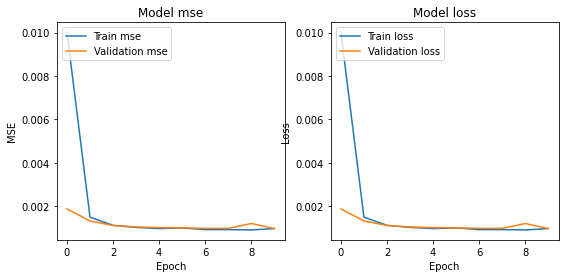

In [50]:
# Plot training & validation mse values
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model mse')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train mse', 'Validation mse'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()


* Evaluate trained model on training set
* Create prediction model and load the predicted weight
* Plot HR, LR and predicted SR images
* calculate metrics between HR/LR and HR/SR images: PSNR, SSIM, MSE

In [52]:
print('Evaluate the model on test data')
loss = model.evaluate(testArr, testLabArr, batch_size=1, verbose=2)
print('test loss:', loss)

Evaluate the model on test data
2670/2670 - 4s - loss: 8.7121e-04 - mse: 8.7121e-04
test loss: [0.0008712058770470321, 0.0008712058770470321]


In [53]:
weight = tf.train.latest_checkpoint(checkpoint_dir)
predModel = ModelDef((None, None, 1))
predModel.load_weights(weight)
predModel.summary()
predModel.compile(optimizer= 'adam', # The optimisation method
              loss=tf.keras.losses.MeanSquaredError(),# Loss function 
              metrics=['mse'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 128)   10496     
_________________________________________________________________
activation_3 (Activation)    (None, None, None, 128)   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
activation_4 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 1)     1601      
_________________________________________________________________
activation_5 (Activation)    (None, None, None, 1)     0         
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
__________________________________________________

#Prediction 

In [54]:
def prediction(predModel, img):
  #predicted image
  predResult = predModel.predict(img)
  return predResult

-------------------Performance Metrics--------------------------------
PSNR of lowres and highres image is 76.7565
PSNR of predicted image and highres image is 64.5372
MSE of predicted image is 0.0229
Structural similarity index (SSI) of predicted image is 0.5081
--------------------------------------------------------------------
-------------------Performance Metrics--------------------------------
PSNR of lowres and highres image is 83.5046
PSNR of predicted image and highres image is 64.9334
MSE of predicted image is 0.0209
Structural similarity index (SSI) of predicted image is 0.5923
--------------------------------------------------------------------
-------------------Performance Metrics--------------------------------
PSNR of lowres and highres image is 81.9784
PSNR of predicted image and highres image is 63.2155
MSE of predicted image is 0.0310
Structural similarity index (SSI) of predicted image is 0.6148
--------------------------------------------------------------------
-

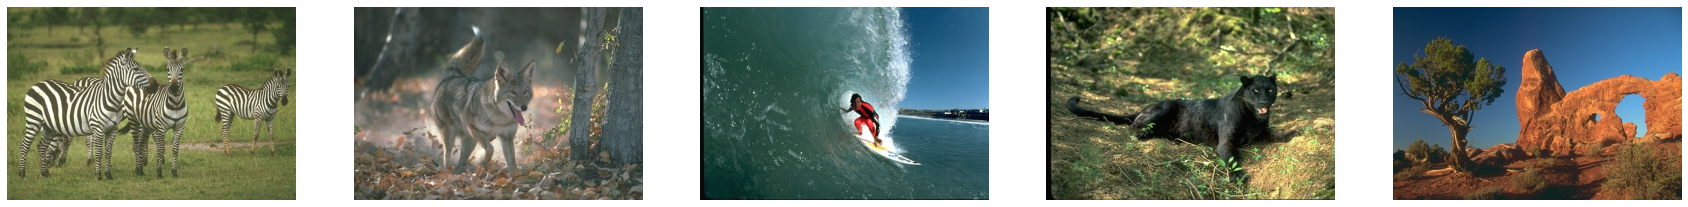

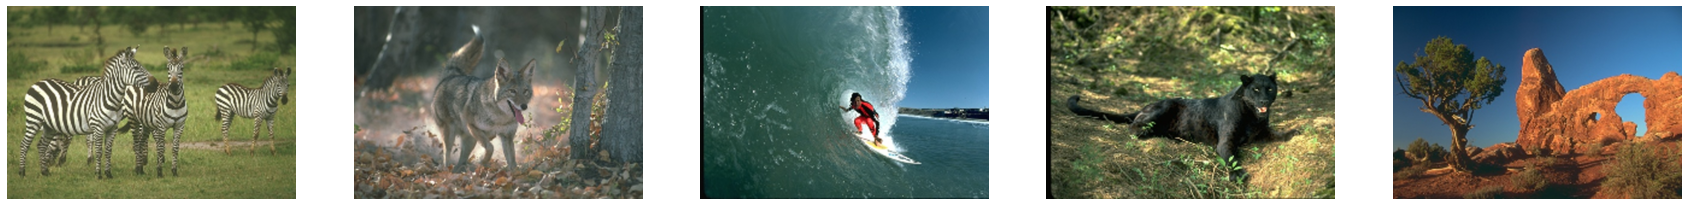

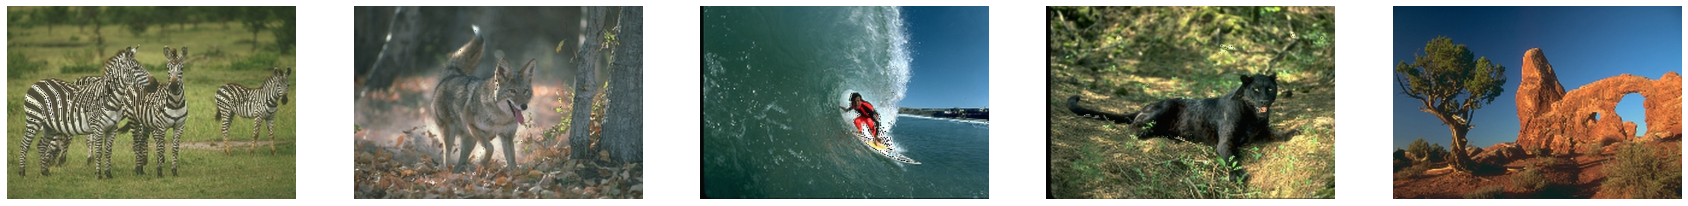

In [61]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage.measure import compare_ssim

selected = np.random.choice(len(lrImgArr), 5)
conversion_psnr = 0.0
prediction_psnr = 0.0
mse = 0.0
ssim1 = 0.0

plt.figure(figsize = (30,30))
for i, ind in enumerate(selected):
  plt.subplot(1, 5, i+1)
  img = cv2.cvtColor(hrLabArr[ind], cv2.COLOR_YCrCb2RGB)
  plt.imshow(img)
  plt.axis('off') 

plt.figure(figsize = (30,30))
for i, ind in enumerate(selected):
  plt.subplot(1, 5, i+1)
  img = cv2.cvtColor(lrImgArr[ind], cv2.COLOR_YCrCb2RGB)
  plt.imshow(img)
  plt.axis('off') 

plt.figure(figsize = (30,30))
for i, ind in enumerate(selected):
  ylr, Crlr, Cblr = cv2.split(lrImgArr[ind])
  shapeX, shapeY = ylr.shape
  y = ylr.reshape(1, shapeX, shapeY, 1)
  y = y / 255.
  predImg = prediction(predModel, y)
  x, y, c, l = predImg.shape
  imgY = predImg.reshape(y, c)
  imgY = imgY * 255.0
  imgY = PIL.Image.fromarray(np.uint8(imgY))
  imgCr = PIL.Image.fromarray(np.uint8(Crlr))
  imgCb = PIL.Image.fromarray(np.uint8(Cblr))
  out_img = PIL.Image.merge('YCbCr',(imgY, imgCb, imgCr)).convert("RGB")
  plt.subplot(1, 5, i+1)
  plt.imshow(out_img)
  plt.axis('off') 

  #performance metrics
  w,h,c = hrLabArr[ind].shape
  lr = lrImgArr[ind] / 255.
  lr = cv2.resize(lr, (h,w))
  out_img = out_img.resize((h,w))
  out_img = img_to_array(out_img) / 255.0
  conversion_psnr = tf.image.psnr(lr, hrLabArr[ind] / 255., max_val = 255.)
  prediction_psnr = tf.image.psnr(out_img, hrLabArr[ind] / 255., max_val = 255.)
  mse = mean_squared_error(out_img, hrLabArr[ind] / 255.)
  ssim1 = ssim(out_img, hrLabArr[ind] / 255., data_range=out_img.max()-out_img.min(), multichannel=True)
  #this function is deprecated to structural_similarity
  #(score, diff) = compare_ssim(out_img, hrLabArr[ind], data_range=out_img.max()-out_img.min() ,full=True, multichannel=True)

  print('-------------------Performance Metrics--------------------------------')
  print("PSNR of lowres and highres image is %.4f" % conversion_psnr)
  print("PSNR of predicted image and highres image is %.4f" % prediction_psnr)
  print("MSE of predicted image is %.4f" % mse)
  print("Structural similarity index (SSI) of predicted image is %.4f" % ssim1)
  print('--------------------------------------------------------------------')

